### Mean variance optimization of portfolios with mutual funds

Markos Flavio B. G. O.

__Context: Portfolio optimization/Modern portfolio theory__

The objective of this notebook is to apply the mean variance optimization to mutual funds available in the XP broker (see the list at https://institucional.xpi.com.br/investimentos/fundos-de-investimento/lista-de-fundos-de-investimento.aspx). The idea is to suggest an optimal portolio, whose components are percentages of the initial investment in each fund, in order to minimize the risj.

The historical data were already downloaded using web scraping techniques (see the file for details: "Downloading data from XP platform.ipynb").
    
__Specific objectives__

    1. Getting and organizing the data
    2. Transforming the data
    3. Looking into the correlations between some funds
    4. Plotting the funds in the average return and volatility space
    5. Mean-variance optimization using PyPortfolioOpt
        5.1 Minimizing volatility
        5.2 Maximizing return for a target risk
        5.3 Minimizing volatility for a target return (Markowitz portfolio)
        5.4 Plotting the minimum variance frontier (Markowitz)
        5.5 Maximizing Sharpe Ratio (Tangency portfolio) -- **not working: optimizer error**
    6. Checking consistency

In [1]:
import pandas as pd
#import yfinance as yf
import numpy as np
import pickle
from itertools import compress
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import CLA

In [2]:
sns.set() # setting seaborn as default style (eve with matplotlib)
plt.rcParams["font.family"] = "serif"

#### 1. Getting and organizing the data

The historical data and additional information of all listed funds were already download using web scrapping and saved in pickle files. Below, we'll clean and format the downloaded data (the most recent data we have available) for further processing.

In [3]:
import pickle
with open('xp_funds_surf_17-08-2020.pickle', 'rb') as fp:
    surface_data = pickle.load(fp)
with open('xp_funds_deep_17-08-2020.pickle', 'rb') as fp:
    deep_data = pickle.load(fp)

Looking at a sample of the data.

In [4]:
surface_data.to_excel("xp_funds.xlsx")

In [5]:
surface_data.iloc[0]

Risco                                RiscoBaixo
Classifiacao MorningStar                      3
Nome                        AZ Quest Termo FIRF
Aplicacao minima                           1000
Taxa adm. a.a. (%)                         0.40
Resgate (D+)                                  6
Rent. mes                                  0.11
Rent. ano                                  2.46
Rent. 12M                                  4.61
Info                                          1
Status                                   Aberto
Codigo                                   800981
Data de inicio                       03/08/2015
Patrimonio                         340308253.24
Patrimonio 12M                     202933148.86
Data da cota                         14/08/2020
Valor da cota                        1.56814310
Taxa perf. (%)                            10.00
Benchmark                                   CDI
Name: 0, dtype: object

In [6]:
surface_data.index = surface_data['Nome']
surface_data.to_excel("xp_funds_surface_data.xlsx")

In [7]:
deep_data.iloc[0]

Inicio                                                                     03/08/2015
PL atual (R$)                                                            340308253.24
PL medio anual (R$)                                                      202933148.86
Objetivos                           O objetivo do fundo AZ Quest Termo FIM é o de ...
Publico-alvo                                                    Investidores em geral
Politica de gestao                  A estratégia do fundo AZ Quest Termo consiste ...
Links                               {'lnkRegulamento': 'https://institucional.xpi....
Aplicação Inicial Mínima                                                             
Movimentação Mínima                                                                  
Saldo de Permanência                                                                 
Taxa de Administração                                                                
Taxa Máxima de Administração                          

It turns out that the historical daily data (only business days) of closing prices are in the 'Daily profitability' attribute of the deep_data DataFrame.

The series hold only the last 36 months of prices(counting from the last day in the data), for mutual funds that began earlier than that. For mutual funds with life span less than 36 months, the data cover the entire series.

In [8]:
deep_data.iloc[0]['Daily profitability'].head()

,Valor
Date,
2017-08-18,0.000000
2017-08-21,0.036770
2017-08-22,0.069693
2017-08-23,0.105299
2017-08-24,0.158592


In [9]:
deep_data.iloc[0]['Daily profitability'].tail()

,Valor
Date,
2020-08-07,20.125135
2020-08-10,20.135880
2020-08-11,20.142493
2020-08-12,20.155123
2020-08-13,20.164910


In [10]:
print(deep_data.shape)
print(surface_data.shape)
n_funds = surface_data.shape[0]

(409, 27)
(409, 19)


As can be seen, the historic data does not output the quota value at each day, but the profitability of each day with respect to the beginning of the series. This kind of statistic is commonly used in the finance industry for comparison between multiple assets. Example (taken from https://institucional.xpi.com.br/investimentos/fundos-de-investimento/detalhes-de-fundos-de-investimento.aspx?F=800981):

<img src="Images/profitability_graph_example.png" width=600 />

Notice that the graph starts at 0%.

Let's build a new data set in which the rows are dates and columns are fund's names.

In [11]:
hist_data = pd.DataFrame()
for i in range(n_funds):
    # do it only if the fund has historical data available
    if surface_data['Info'][i] == 1:
        name = surface_data['Nome'][i]
        fund_data = deep_data['Daily profitability'][i].copy()
        fund_data.rename(columns={'Valor': name}, inplace=True, errors='raise')
        hist_data = pd.concat([hist_data, fund_data], axis=1, sort=True)

In [12]:
hist_data

,AZ Quest Termo FIRF,Bradesco Asset FIC FIRF CP LP Plus,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend DI Simples FIRF,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,ARX Denali FIC FIRF CP,...,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM,XP Long Biased Advisory FIC FIM,XP Long Term Equity FIC FIM,XP Macro Plus FIC FIM,XPA Portfolio Private II FIC FIM CP,Absolute Alpha Marb Advisory FIC FIM,AF Invest Geraes 30 FIRF CP,FMB FIC FIM CP
2017-08-18,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-21,0.036770,NaN,0.034076,0.038848,0.033997,NaN,0.033745,-0.035854,0.036886,NaN,...,0.057626,0.015283,-0.075909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-22,0.069693,NaN,0.072053,0.073860,0.068362,NaN,0.067589,-0.113472,0.076370,NaN,...,1.582540,1.628475,1.261966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-23,0.105299,NaN,0.102633,0.111004,0.102396,NaN,0.101388,0.000877,0.109881,NaN,...,1.982759,2.043647,1.707249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-24,0.158592,NaN,0.136514,0.149325,0.136431,NaN,0.135171,-0.009732,0.144353,NaN,...,3.127487,3.233851,2.682267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-11,20.142493,1.42074,13.848101,17.103729,17.679781,3.134624,17.299876,21.562997,15.362289,9.281231,...,71.557628,75.745080,45.075576,9.723999,36.794801,17.395895,8.057494,3.802412,10.78500,12.474387
2020-08-12,20.155123,1.40832,13.845999,17.137945,17.687909,3.142301,17.307742,21.545746,15.363653,9.277954,...,70.950636,75.101191,44.913759,9.602533,36.188323,17.685331,8.062112,3.789085,10.79997,12.576265
2020-08-13,20.164910,1.40171,13.813298,17.133222,17.695632,3.150158,17.315679,21.523232,15.375246,9.291756,...,68.992403,73.068912,43.571609,8.594860,35.383943,17.157214,7.883468,3.805588,10.82287,12.342056
2020-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see most funds have data until '18-08-2017', the initial date of the sampling. The ones with shorter life periods, have NaN instead. Also, some funds have profitability values for the last two days: '2020-08-14' and '2020-08-17'. Possibly, the data for these funds were updated earlier than the rest in the XP plaform. We decided to remove profitability for these two days to maintain consistency between funds data.

In [13]:
print(hist_data.loc['2020-08-14'].dropna().shape)
print(hist_data.loc['2020-08-17'].dropna().shape)
hist_data = hist_data.drop(['2020-08-14', '2020-08-17'], axis=0)
hist_data.shape

(84,)
(1,)


(749, 375)

For the sake of the simplified analysis covered here, we'll consider only funds with life span larger than 36 months, i.e. with valid values for the date '2017-08-18'.

In [14]:
hist_data

,AZ Quest Termo FIRF,Bradesco Asset FIC FIRF CP LP Plus,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend DI Simples FIRF,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,ARX Denali FIC FIRF CP,...,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM,XP Long Biased Advisory FIC FIM,XP Long Term Equity FIC FIM,XP Macro Plus FIC FIM,XPA Portfolio Private II FIC FIM CP,Absolute Alpha Marb Advisory FIC FIM,AF Invest Geraes 30 FIRF CP,FMB FIC FIM CP
2017-08-18,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-21,0.036770,NaN,0.034076,0.038848,0.033997,NaN,0.033745,-0.035854,0.036886,NaN,...,0.057626,0.015283,-0.075909,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-22,0.069693,NaN,0.072053,0.073860,0.068362,NaN,0.067589,-0.113472,0.076370,NaN,...,1.582540,1.628475,1.261966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-23,0.105299,NaN,0.102633,0.111004,0.102396,NaN,0.101388,0.000877,0.109881,NaN,...,1.982759,2.043647,1.707249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-24,0.158592,NaN,0.136514,0.149325,0.136431,NaN,0.135171,-0.009732,0.144353,NaN,...,3.127487,3.233851,2.682267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07,20.125135,1.39390,13.885726,17.092011,17.663921,3.119125,17.284114,21.620241,15.331005,9.252076,...,72.671582,76.900731,47.366988,11.444452,38.533326,17.613538,8.578156,3.949426,10.70273,13.309943
2020-08-10,20.135880,1.40391,13.855312,17.094935,17.671939,3.126882,17.291982,21.606751,15.351458,9.267421,...,73.154162,77.407469,47.689331,11.686572,37.624090,17.919560,8.418934,3.946318,10.75048,13.070762
2020-08-11,20.142493,1.42074,13.848101,17.103729,17.679781,3.134624,17.299876,21.562997,15.362289,9.281231,...,71.557628,75.745080,45.075576,9.723999,36.794801,17.395895,8.057494,3.802412,10.78500,12.474387
2020-08-12,20.155123,1.40832,13.845999,17.137945,17.687909,3.142301,17.307742,21.545746,15.363653,9.277954,...,70.950636,75.101191,44.913759,9.602533,36.188323,17.685331,8.062112,3.789085,10.79997,12.576265


In [15]:
old_funds = list(compress(list(hist_data.columns), list(hist_data.loc['2017-08-18'].notna())))
hist_data = hist_data[old_funds]
hist_data

,AZ Quest Termo FIRF,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,Az Quest Low Vol FIM,AZ Quest Luce FIC FI RF CP LP,AZ Quest Valore FI Renda Fixa CP,...,Votorantim FIC de FI Cambial Dólar,Western Asset FIA BDR Nivel I,Western Asset Hedge Dólar FI Cambial,Western Asset US Index 500 FIM,XP Crédito Estruturado 180 FIC FIM CP,XP Dividendos 30 FIC FIA,XP Dividendos FIA,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM
2017-08-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08-21,0.036770,0.034076,0.038848,0.033997,0.033745,-0.035854,0.036886,0.007061,0.036411,0.042889,...,0.640436,0.657085,0.631083,0.080375,0.070954,-0.051191,-0.018555,0.057626,0.015283,-0.075909
2017-08-22,0.069693,0.072053,0.073860,0.068362,0.067589,-0.113472,0.076370,0.053834,0.071162,0.068299,...,0.542046,2.328337,0.532414,1.081769,0.107007,1.585491,1.578564,1.582540,1.628475,1.261966
2017-08-23,0.105299,0.102633,0.111004,0.102396,0.101388,0.000877,0.109881,0.080313,0.103592,0.094552,...,-0.236944,0.461248,-0.251245,0.640639,0.148019,1.696935,1.660680,1.982759,2.043647,1.707249
2017-08-24,0.158592,0.136514,0.149325,0.136431,0.135171,-0.009732,0.144353,0.109967,0.141128,0.126161,...,-0.086072,0.366617,-0.098910,0.671760,0.183357,2.185026,2.297477,3.127487,3.233851,2.682267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07,20.125135,13.885726,17.092011,17.663921,17.284114,21.620241,15.331005,17.694258,13.768625,14.022815,...,80.182159,166.134904,78.230340,47.221118,26.599614,47.621809,51.444609,72.671582,76.900731,47.366988
2020-08-10,20.135880,13.855312,17.094935,17.671939,17.291982,21.606751,15.351458,17.734234,13.794338,14.076464,...,81.282556,168.474955,79.319561,47.662123,26.608967,47.182580,50.987293,73.154162,77.407469,47.689331
2020-08-11,20.142493,13.848101,17.103729,17.679781,17.299876,21.562997,15.362289,17.762319,13.830406,14.094578,...,79.322701,164.779019,77.386081,46.931122,26.634045,46.107394,49.860670,71.557628,75.745080,45.075576
2020-08-12,20.155123,13.845999,17.137945,17.687909,17.307742,21.545746,15.363653,17.781134,13.826231,14.061846,...,81.331814,170.528271,79.381472,48.344753,26.650415,44.723171,48.398140,70.950636,75.101191,44.913759


Another issue of this dataset is that some funds don't have values for trading days. See the example below, in which the profitability for the July 23 of 2020 (a thursday and not a holliday day) is not available for some arbitrary fund:

In [16]:
hist_data['AZ Quest Termo FIRF'].iloc[-17:-13]

2020-07-22    19.967846
2020-07-23          NaN
2020-07-24    19.985542
2020-07-27    19.998340
Name: AZ Quest Termo FIRF, dtype: float64

To solve this problem, we'll use the fillna() method from Pandas.

In [17]:
hist_data = hist_data.fillna(method='ffill')
hist_data['AZ Quest Termo FIRF'].iloc[-17:-13]

2020-07-22    19.967846
2020-07-23    19.967846
2020-07-24    19.985542
2020-07-27    19.998340
Name: AZ Quest Termo FIRF, dtype: float64

#### 2. Transforming the data

Further below, we'll use the PyPortfolioOpt library to find the optmium portfolio through mean-variance optimization. To build the efficient frontier using this library, it's necessary to proivide a series of expected returns and a covariance matrix. The library has its own methods to calculate such statistics, which are done from a data set of closing prices.

In [18]:
hist_data

,AZ Quest Termo FIRF,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,Az Quest Low Vol FIM,AZ Quest Luce FIC FI RF CP LP,AZ Quest Valore FI Renda Fixa CP,...,Votorantim FIC de FI Cambial Dólar,Western Asset FIA BDR Nivel I,Western Asset Hedge Dólar FI Cambial,Western Asset US Index 500 FIM,XP Crédito Estruturado 180 FIC FIM CP,XP Dividendos 30 FIC FIA,XP Dividendos FIA,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM
2017-08-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08-21,0.036770,0.034076,0.038848,0.033997,0.033745,-0.035854,0.036886,0.007061,0.036411,0.042889,...,0.640436,0.657085,0.631083,0.080375,0.070954,-0.051191,-0.018555,0.057626,0.015283,-0.075909
2017-08-22,0.069693,0.072053,0.073860,0.068362,0.067589,-0.113472,0.076370,0.053834,0.071162,0.068299,...,0.542046,2.328337,0.532414,1.081769,0.107007,1.585491,1.578564,1.582540,1.628475,1.261966
2017-08-23,0.105299,0.102633,0.111004,0.102396,0.101388,0.000877,0.109881,0.080313,0.103592,0.094552,...,-0.236944,0.461248,-0.251245,0.640639,0.148019,1.696935,1.660680,1.982759,2.043647,1.707249
2017-08-24,0.158592,0.136514,0.149325,0.136431,0.135171,-0.009732,0.144353,0.109967,0.141128,0.126161,...,-0.086072,0.366617,-0.098910,0.671760,0.183357,2.185026,2.297477,3.127487,3.233851,2.682267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07,20.125135,13.885726,17.092011,17.663921,17.284114,21.620241,15.331005,17.694258,13.768625,14.022815,...,80.182159,166.134904,78.230340,47.221118,26.599614,47.621809,51.444609,72.671582,76.900731,47.366988
2020-08-10,20.135880,13.855312,17.094935,17.671939,17.291982,21.606751,15.351458,17.734234,13.794338,14.076464,...,81.282556,168.474955,79.319561,47.662123,26.608967,47.182580,50.987293,73.154162,77.407469,47.689331
2020-08-11,20.142493,13.848101,17.103729,17.679781,17.299876,21.562997,15.362289,17.762319,13.830406,14.094578,...,79.322701,164.779019,77.386081,46.931122,26.634045,46.107394,49.860670,71.557628,75.745080,45.075576
2020-08-12,20.155123,13.845999,17.137945,17.687909,17.307742,21.545746,15.363653,17.781134,13.826231,14.061846,...,81.331814,170.528271,79.381472,48.344753,26.650415,44.723171,48.398140,70.950636,75.101191,44.913759


As we have the profitability historic data instead of quota values, we'll simulate an initial price of R\$1,00 at the beggining of the time series, to build a proxy historical data of prices.

Intuiton: we don't have values at particular time steps $t$, but percentages with respect to the first price $P_{t=0}$ in the profitabilities data. We know that $\Delta P_t = \frac{P_t-P_0}{P_0}$, where $t=1,2,...T$. Thus, assuming that $P_0=1$, we have that $P_t = \Delta P_t + 1$.

In [19]:
df = (hist_data/100) # 5(%) becomes 0.05
df = df + 1
df.tail()

,AZ Quest Termo FIRF,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,Az Quest Low Vol FIM,AZ Quest Luce FIC FI RF CP LP,AZ Quest Valore FI Renda Fixa CP,...,Votorantim FIC de FI Cambial Dólar,Western Asset FIA BDR Nivel I,Western Asset Hedge Dólar FI Cambial,Western Asset US Index 500 FIM,XP Crédito Estruturado 180 FIC FIM CP,XP Dividendos 30 FIC FIA,XP Dividendos FIA,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM
2020-08-07,1.201251,1.138857,1.170920,1.176639,1.172841,1.216202,1.153310,1.176943,1.137686,1.140228,...,1.801822,2.661349,1.782303,1.472211,1.265996,1.476218,1.514446,1.726716,1.769007,1.473670
2020-08-10,1.201359,1.138553,1.170949,1.176719,1.172920,1.216068,1.153515,1.177342,1.137943,1.140765,...,1.812826,2.684750,1.793196,1.476621,1.266090,1.471826,1.509873,1.731542,1.774075,1.476893
2020-08-11,1.201425,1.138481,1.171037,1.176798,1.172999,1.215630,1.153623,1.177623,1.138304,1.140946,...,1.793227,2.647790,1.773861,1.469311,1.266340,1.461074,1.498607,1.715576,1.757451,1.450756
2020-08-12,1.201551,1.138460,1.171379,1.176879,1.173077,1.215457,1.153637,1.177811,1.138262,1.140618,...,1.813318,2.705283,1.793815,1.483448,1.266504,1.447232,1.483981,1.709506,1.751012,1.449138
2020-08-13,1.201649,1.138133,1.171332,1.176956,1.173157,1.215232,1.153752,1.178070,1.138372,1.140346,...,1.785510,2.664031,1.766101,1.485225,1.266690,1.416152,1.451356,1.689924,1.730689,1.435716


#### 3. Looking into the correlations between some funds

In [20]:
df_pct = df.pct_change() # getting daily returns
df_pct.head()

,AZ Quest Termo FIRF,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,Az Quest Low Vol FIM,AZ Quest Luce FIC FI RF CP LP,AZ Quest Valore FI Renda Fixa CP,...,Votorantim FIC de FI Cambial Dólar,Western Asset FIA BDR Nivel I,Western Asset Hedge Dólar FI Cambial,Western Asset US Index 500 FIM,XP Crédito Estruturado 180 FIC FIM CP,XP Dividendos 30 FIC FIA,XP Dividendos FIA,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM
2017-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-21,0.000368,0.000341,0.000388,0.000340,0.000337,-0.000359,0.000369,0.000071,0.000364,0.000429,...,0.006404,0.006571,0.006311,0.000804,0.000710,-0.000512,-0.000186,0.000576,0.000153,-0.000759
2017-08-22,0.000329,0.000380,0.000350,0.000344,0.000338,-0.000776,0.000395,0.000468,0.000347,0.000254,...,-0.000978,0.016603,-0.000981,0.010006,0.000360,0.016375,0.015974,0.015240,0.016129,0.013389
2017-08-23,0.000356,0.000306,0.000371,0.000340,0.000338,0.001145,0.000335,0.000265,0.000324,0.000262,...,-0.007748,-0.018246,-0.007795,-0.004364,0.000410,0.001097,0.000808,0.003940,0.004085,0.004397
2017-08-24,0.000532,0.000338,0.000383,0.000340,0.000337,-0.000106,0.000344,0.000296,0.000375,0.000316,...,0.001512,-0.000942,0.001527,0.000309,0.000353,0.004799,0.006264,0.011225,0.011664,0.009587


In [21]:
def heatmap(x, y, size):
    '''
    Source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec 
    '''
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 1000
    
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s= size_scale, # Vector of square sizes, proportional to size parameter
        marker='h', # Use hexagons as scatterplot marker
        edgecolors='k',
        facecolors='none',
    )
    
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='h' # Use hexagons as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    # set the squares to the center of the cells
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    # aligning left and bottom lines
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

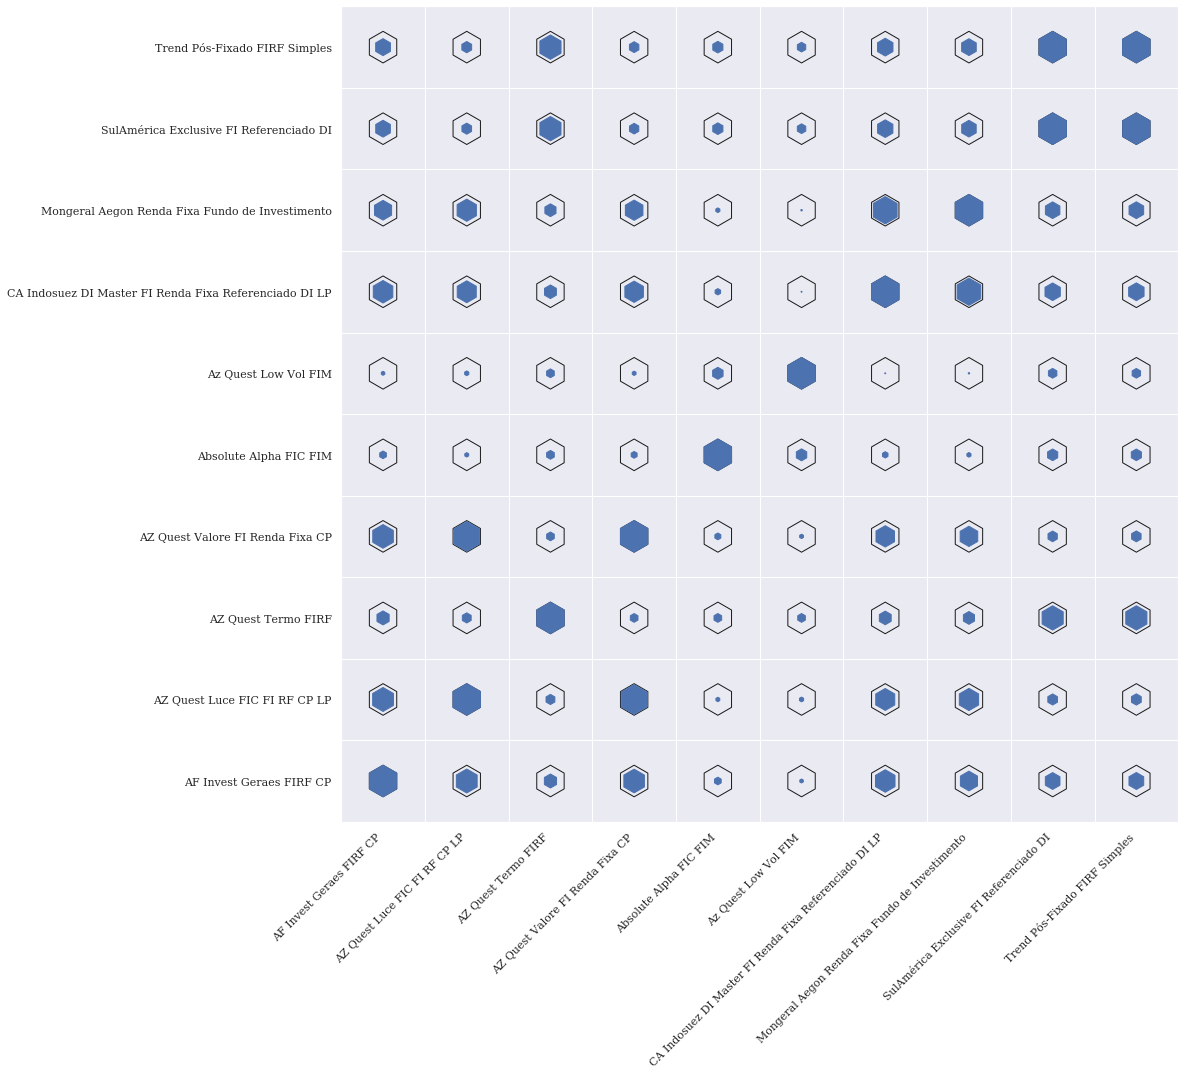

In [22]:
columns = df_pct.columns[:10] # filtering the columns for better view
corr = df_pct[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(x=corr['x'], y=corr['y'], size=corr['value'].abs())

#### 4. Plotting the funds in the average return and volatility space

Before starting with the optimization library, let's build a function that plots the mean-variance volatility space of the individual funds. If an array of custom weights representing a portfolio is available, it also the portfolio in the space.

To be able to evaluate by ourselves the portfolio expected return and volatility, we have to build the matrix of returns.

In [23]:
df_pct = df.pct_change()
df_pct.head()

,AZ Quest Termo FIRF,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,Az Quest Low Vol FIM,AZ Quest Luce FIC FI RF CP LP,AZ Quest Valore FI Renda Fixa CP,...,Votorantim FIC de FI Cambial Dólar,Western Asset FIA BDR Nivel I,Western Asset Hedge Dólar FI Cambial,Western Asset US Index 500 FIM,XP Crédito Estruturado 180 FIC FIM CP,XP Dividendos 30 FIC FIA,XP Dividendos FIA,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM
2017-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-21,0.000368,0.000341,0.000388,0.000340,0.000337,-0.000359,0.000369,0.000071,0.000364,0.000429,...,0.006404,0.006571,0.006311,0.000804,0.000710,-0.000512,-0.000186,0.000576,0.000153,-0.000759
2017-08-22,0.000329,0.000380,0.000350,0.000344,0.000338,-0.000776,0.000395,0.000468,0.000347,0.000254,...,-0.000978,0.016603,-0.000981,0.010006,0.000360,0.016375,0.015974,0.015240,0.016129,0.013389
2017-08-23,0.000356,0.000306,0.000371,0.000340,0.000338,0.001145,0.000335,0.000265,0.000324,0.000262,...,-0.007748,-0.018246,-0.007795,-0.004364,0.000410,0.001097,0.000808,0.003940,0.004085,0.004397
2017-08-24,0.000532,0.000338,0.000383,0.000340,0.000337,-0.000106,0.000344,0.000296,0.000375,0.000316,...,0.001512,-0.000942,0.001527,0.000309,0.000353,0.004799,0.006264,0.011225,0.011664,0.009587


In [24]:
# computing the annualized metrics (in %)
df_pct_ann = pd.DataFrame({
    'Mean': ((1+df_pct.mean())**252-1), # effective
    'Volatility': df_pct.std()*np.sqrt(252)
}).transpose()
df_pct_ann

,AZ Quest Termo FIRF,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,Az Quest Low Vol FIM,AZ Quest Luce FIC FI RF CP LP,AZ Quest Valore FI Renda Fixa CP,...,Votorantim FIC de FI Cambial Dólar,Western Asset FIA BDR Nivel I,Western Asset Hedge Dólar FI Cambial,Western Asset US Index 500 FIM,XP Crédito Estruturado 180 FIC FIM CP,XP Dividendos 30 FIC FIA,XP Dividendos FIA,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM
Mean,0.063843,0.044574,0.054734,0.056426,0.055276,0.067959,0.049396,0.056874,0.044733,0.045354,...,0.229713,0.419746,0.224551,0.169866,0.082940,0.164820,0.176809,0.254614,0.267390,0.192117
Volatility,0.001583,0.005967,0.004691,0.000990,0.000976,0.012331,0.007921,0.014449,0.014075,0.014829,...,0.151653,0.202273,0.148139,0.216776,0.008314,0.264585,0.271885,0.312404,0.318941,0.323583


In [29]:
def plot_mv_space(df, cov_matrix, list_w = []):
    
    X = np.array(df.iloc[1]) # volatility in the x-axis
    Y = np.array(df.iloc[0])
    C = list(df.columns)
    plt.figure(figsize=(20,10))
    
    if list_w:
        for i, w in enumerate(list_w):
            w = np.array(w)
            p_er = np.dot(w, df.loc['Mean']) # portfolio expected return
            w = w.reshape(1,-1)
            cov_matrix = np.array(cov_matrix)
            p_std = np.sqrt((w.dot(cov_matrix)).dot(w.T)[0][0])*np.sqrt(252) # we have to annualize portolio std
            if len(list_w) == 1:
                plt.plot(p_std, p_er, 'o', markersize=12, alpha=.6, color='red', label='Portfolio')
            elif i == 0: # plot the label for the first portfolio
                plt.plot(p_std, p_er, 'o', markersize=12, alpha=.6, color='red', label='Portfolios')
            else:
                plt.plot(p_std, p_er, 'o', markersize=12, alpha=.6, color='red')
            w = w.ravel() # for the last plot
            
        plt.plot(X, Y, 'o', color='blue', alpha=.2, label='Other funds')
        
        if len(list_w) == 1:
            for x, y, c, pct in zip(X[w>0], Y[w>0], np.array(C)[w>0], w[w>0]):
                plt.plot(x, y, 's', alpha=1, label='{0}: {1}%'.format(c, np.round(pct*100,2)))
        
        plt.title('Average annual return and volatility space')
        plt.xlabel('Annual volatility (%)'); plt.ylabel('Avg. annual return (%)')
        #plt.xlim([-5, max(X)+5]); plt.ylim([-5, max(Y)+5])
        #plt.xlim([0, 10]); plt.ylim([0, 10]) zooming-in
        plt.legend()
        print('Portfolio annual volatility: ', p_std)
        print('Portfolio annual expected return: ', p_er)
        return p_std, p_er
    else:
        plt.plot(X, Y, 'o', color='blue', alpha=.4)
        plt.title('Average annual return and volatility space')
        plt.xlabel('Annual volatility (%)'); plt.ylabel('Avg. annual return (%)')
        #plt.xlim([-5, max(X)+5]); plt.ylim([-5, max(Y)+5])
        return

To test if the function is working we can build a portolfio with just one asset and see if the annual expected return and volatility of the portfolio are equal to the values for this asset alone.

Portfolio annual volatility:  0.3236521874046695
Portfolio annual expected return:  0.25595977941858017


(0.3236521874046695, 0.25595977941858017)

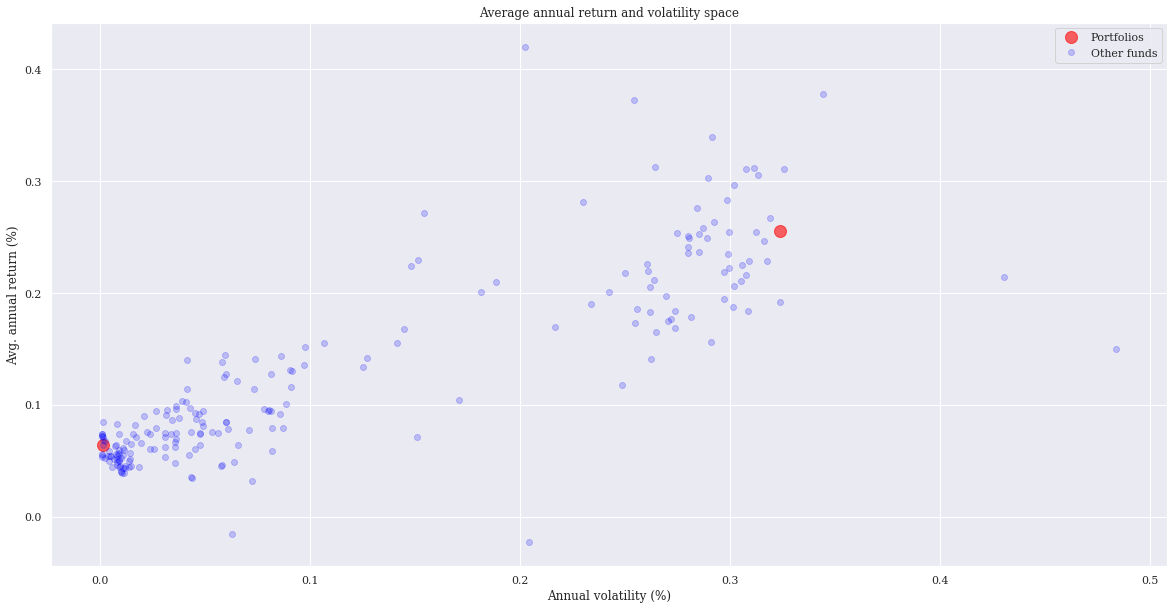

In [30]:
list_w = []
w_test = np.zeros(df_pct_ann.shape[1])
w_test[0] = 1.0; list_w.append(np.copy(w_test))
w_test[-1] = 1.0; list_w.append(w_test)
plot_mv_space(df_pct_ann, df_pct.cov(), list_w)

Testing with a portoflio that has a uniform combination of the top 5% return funds and top 5% lowest volatility funds.

Number of assets in the test portfolio:  10
Number of assets in the test portfolio:  0.9999999999999999
Portfolio annual volatility:  0.1178331060333196
Portfolio annual expected return:  0.21326496701645023


(0.1178331060333196, 0.21326496701645023)

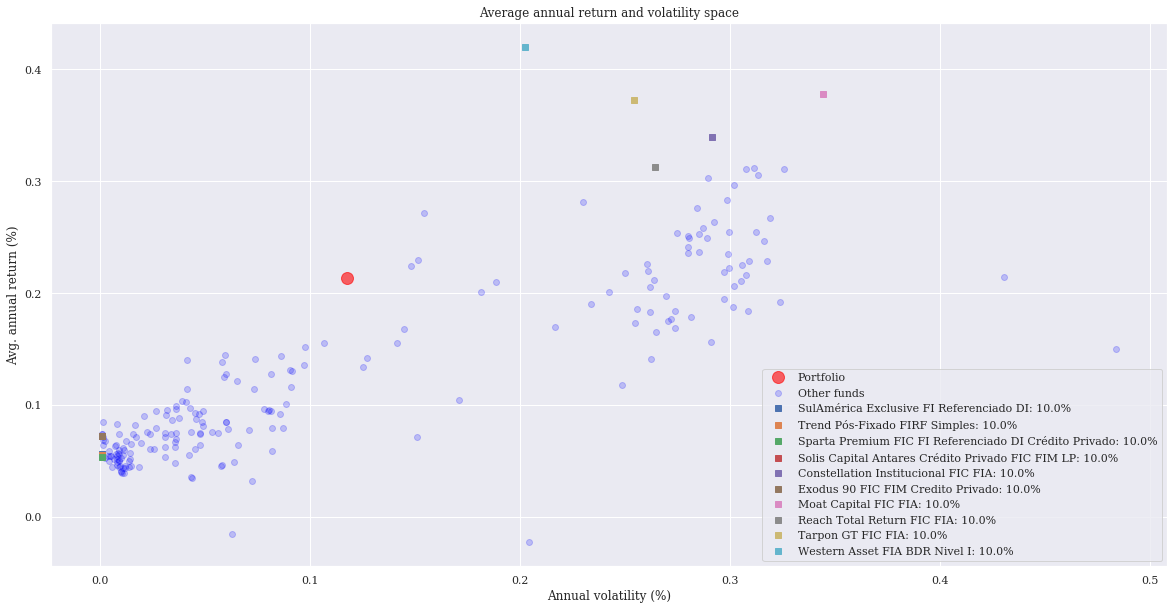

In [31]:
highest_return = list(df_pct_ann.transpose().sort_values(by='Mean', ascending=False)[:5].index)
lowest_vol = list(df_pct_ann.transpose().sort_values(by='Volatility', ascending=True)[:5].index)
test_port = highest_return + lowest_vol
print('Number of assets in the test portfolio: ', len(test_port))
weights = []
for fund in list(df_pct_ann.columns):
    if fund in test_port:
        weights.append(.1)
    else:
        weights.append(0.0)
print('Number of assets in the test portfolio: ', sum(weights))
list_w = []; list_w.append(weights)
plot_mv_space(df_pct_ann, df_pct.cov(), list_w)

We could get a very good portfolio just by combining equally the portfolios with highest returns and those with lowest volatility. Let's improve the performance by using optimization methods.

#### 5. Mean-variance optimization using PyPortfolioOpt

Below, we instantiate an Efficient Frontier object. It's a general framework that allows us to run several optimization objectives. Weights are bounded to be positive (short selling not allowed).

It's critical that the expected returns put into this objects are annualized and in percentage form. For example, 5% must be put as 0.05.

Also, the covariance matrix must be annualized. Each daily entry must be multiplied by 252. 

In [32]:
ef = EfficientFrontier(np.array(df_pct_ann.loc['Mean']), df_pct.cov()*252, weight_bounds=(0, 1))

Unfortunately, most optimziers could not achieve a solution with lower bounds on weights higher than zero, such that 0.01. We can get around that (in terms of practicality and not optimization), by using the function below.

In [33]:
def redistribute_weights(d, min_p):
    '''
    Redistribute the weights of the assets, so that the minimum percentage on any asset is satisfied.
    '''
    for k, v in d.items(): # removing weights less than p_min
        if v < min_p:
            d[k] = 0.0
    factor=1.0/sum(d.values())
    for k, v in d.items(): # normalizing
        if v >= min_p:
            d[k] = d[k]*factor
    return d

#### 5.1 Minimizing volatility

Finds asset weights that minimize portfolio volatility

In [34]:
ef = EfficientFrontier(np.array(df_pct_ann.loc['Mean']), df_pct.cov()*252, weight_bounds=(0, 1))
ef.min_volatility()
weights = redistribute_weights(dict(ef.clean_weights()), 0.01)
list_w = []; list_w.append(list(weights.values()))

Portfolio annual volatility:  0.0009827819852691242
Portfolio annual expected return:  0.05545966726979769


(0.0009827819852691242, 0.05545966726979769)

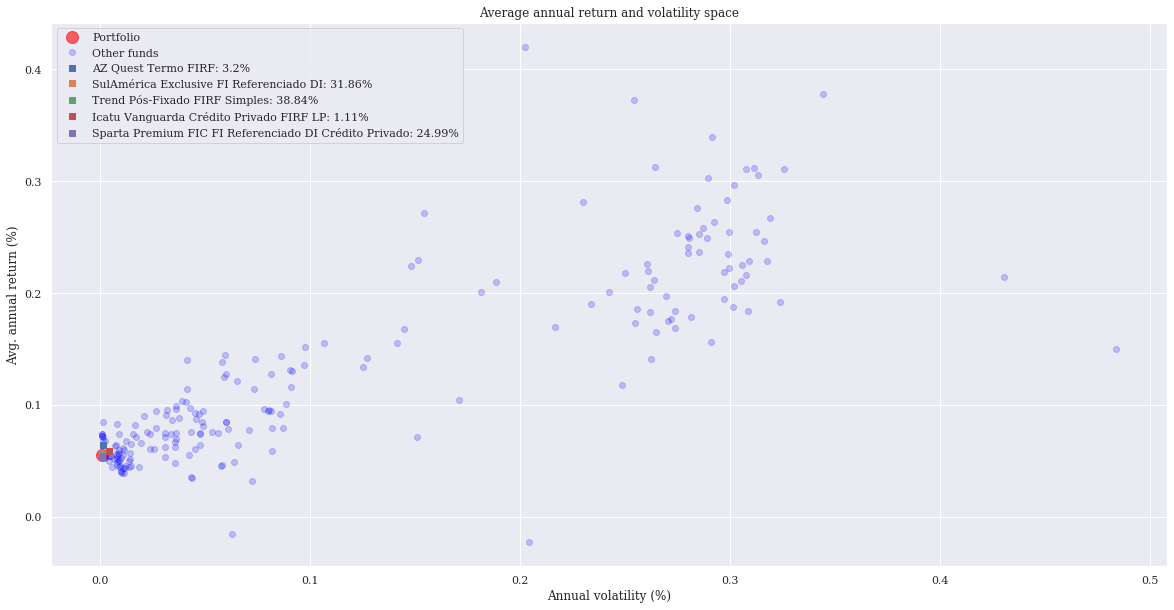

In [35]:
plot_mv_space(df_pct_ann, df_pct.cov(), list_w)

#### 5.2 Maximizing return for a target risk

Portfolio annual volatility:  0.10002105178532594
Portfolio annual expected return:  0.32185664114200735


(0.10002105178532594, 0.32185664114200735)

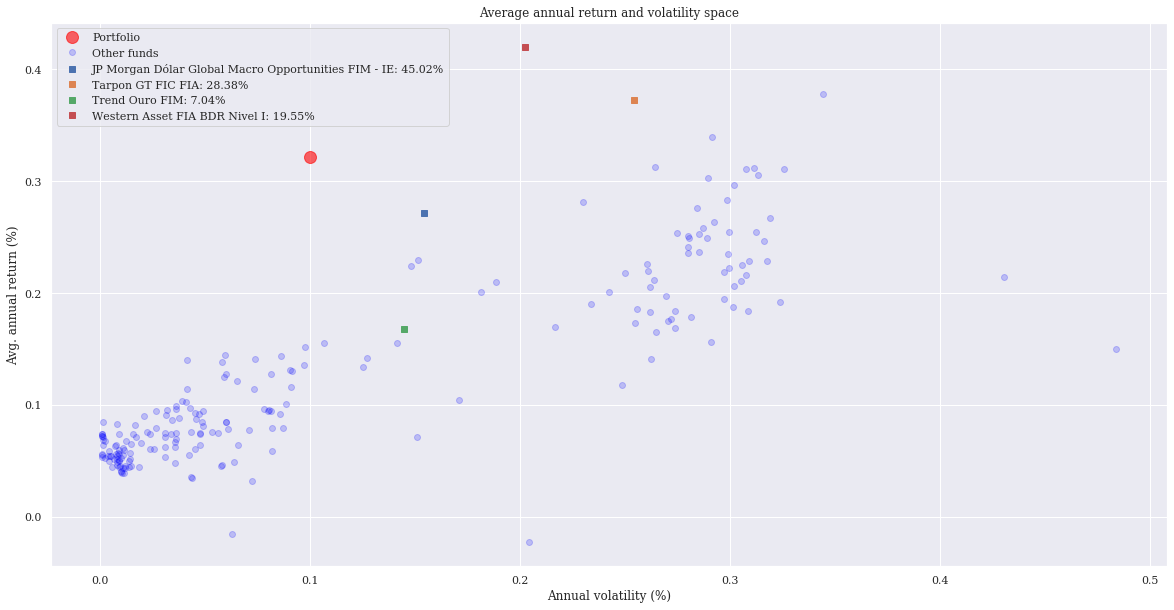

In [36]:
target_annual_vol = 0.1
ef = EfficientFrontier(np.array(df_pct_ann.loc['Mean']), df_pct.cov()*252, weight_bounds=(0, 1))
weights = ef.efficient_risk(target_annual_vol)
weights = redistribute_weights(dict(ef.clean_weights()), 0.01)
list_w = []; list_w.append(list(weights.values()))
plot_mv_space(df_pct_ann, df_pct.cov(), list_w)

#### 5.3 Minimizing volatility for a target return (Markowitz portfolio)

Portfolio annual volatility:  0.04120209882647791
Portfolio annual expected return:  0.1999999525168652


(0.04120209882647791, 0.1999999525168652)

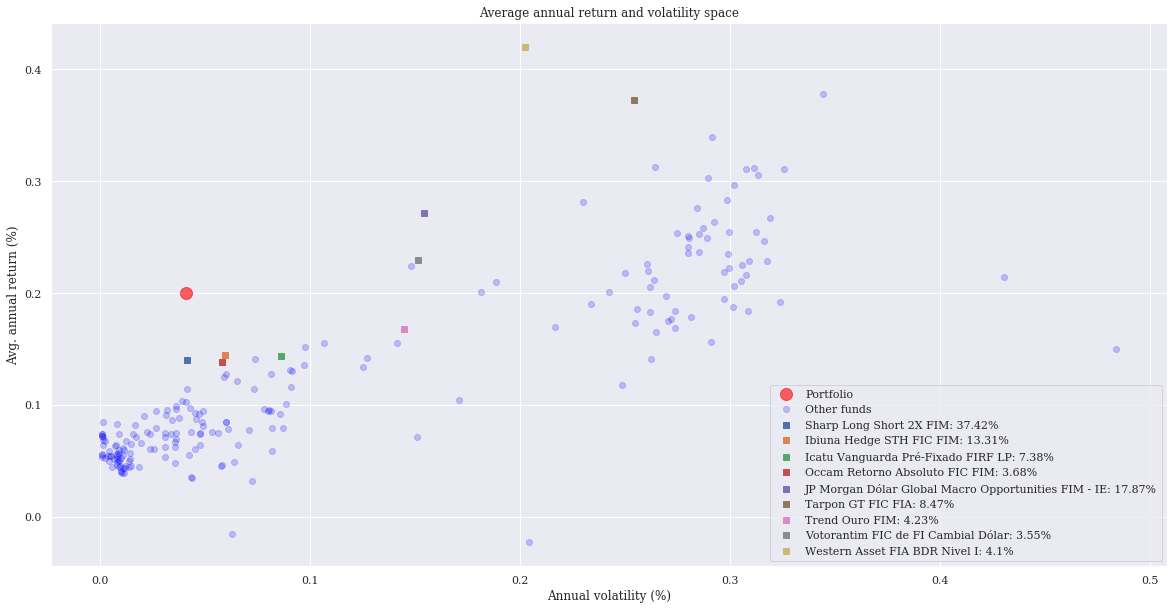

In [37]:
target_annual_ret = .2
ef = EfficientFrontier(np.array(df_pct_ann.loc['Mean']), df_pct.cov()*252, weight_bounds=(0, 1))
weights = ef.efficient_return(target_annual_ret)
weights = redistribute_weights(dict(ef.clean_weights()), 0.01)
list_w = []; list_w.append(list(weights.values()))
plot_mv_space(df_pct_ann, df_pct.cov(), list_w)

#### 5.4 Plotting the minimum variance frontier (Markowitz)

Portfolio annual volatility:  0.15680540312017324
Portfolio annual expected return:  0.389999860356382


(0.15680540312017324, 0.389999860356382)

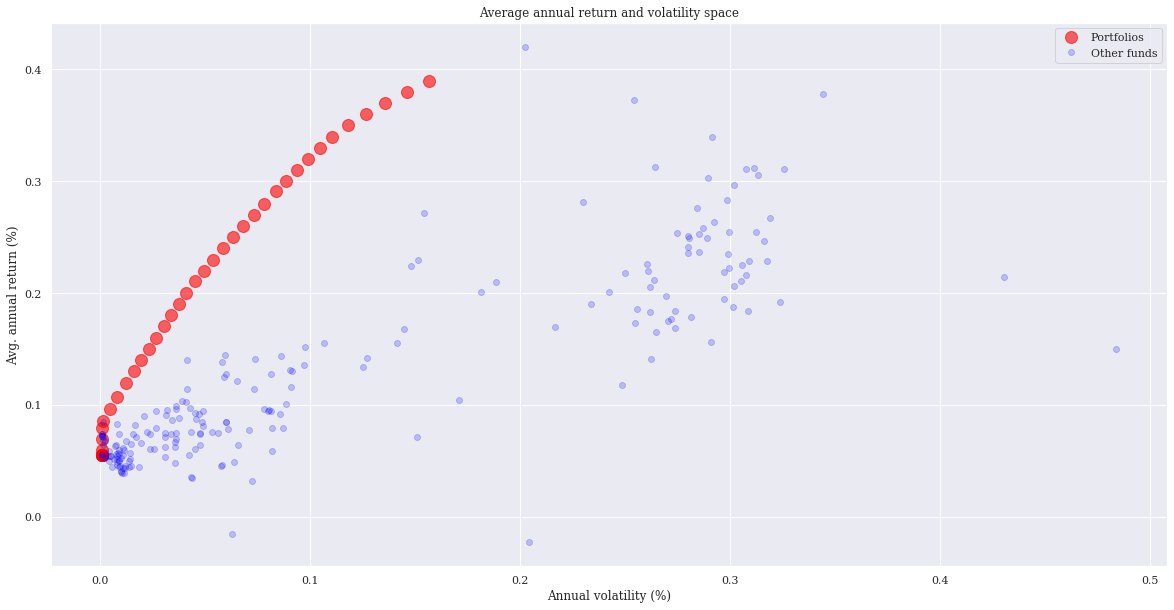

In [38]:
list_w = []
for target_annual_ret in np.arange(0.0, 0.4, 0.01):
    ef = EfficientFrontier(np.array(df_pct_ann.loc['Mean']), df_pct.cov()*252, weight_bounds=(0, 1))
    weights = ef.efficient_return(target_annual_ret)
    weights = redistribute_weights(dict(ef.clean_weights()), 0.01)
    list_w.append(list(weights.values()))
plot_mv_space(df_pct_ann, df_pct.cov(), list_w)

#### 5.5 Maximizing Sharpe Ratio (Tangency portfolio)

*Currently, the embed solver is not correctly working for this otimization problem with the given inputs.*

In [39]:
ef = EfficientFrontier(np.array(df_pct_ann.loc['Mean']), df_pct.cov()*252, weight_bounds=(0, 1))
ef.max_sharpe()
weights = redistribute_weights(dict(ef.clean_weights()), 0.01)
list_w = []; list_w.append(list(weights.values()))
plot_mv_space(df_pct_ann, df_pct.cov(), list_w)

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

#### 6. Checking consistency

As already told, the PyPortfolioOpt library has an in-built method of computing the expected return and standard deviation from a matrix of closing prices. There're two form of computing the annual expected return, with (that gives us the effective rate) and without compounding (that gives us the nominal rate).

Also, there're several form to compute the covariance matrix, depending on the model you want to use (see https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html for details). For example, the *exp_cov* method puts more weights on recent data.

Let's check if the results we've got from our own methods of computing returns and volatility are matching the results from the library:

In [40]:
mu_nom = mean_historical_return(df, compounding=False)
mu_eff = mean_historical_return(df, compounding=True)
print(mu_nom[:3])
print(mu_eff[:3])

AZ Quest Termo FIRF                                       0.061895
CA Indosuez DI Master FI Renda Fixa Referenciado DI LP    0.043613
Mongeral Aegon Renda Fixa Fundo de Investimento           0.053294
dtype: float64
AZ Quest Termo FIRF                                       0.063843
CA Indosuez DI Master FI Renda Fixa Referenciado DI LP    0.044574
Mongeral Aegon Renda Fixa Fundo de Investimento           0.054734
dtype: float64


In [41]:
df_pct_ann.loc['Mean'][:3]

AZ Quest Termo FIRF                                       0.063843
CA Indosuez DI Master FI Renda Fixa Referenciado DI LP    0.044574
Mongeral Aegon Renda Fixa Fundo de Investimento           0.054734
Name: Mean, dtype: float64

We can see that our returns indeed match the results given by library, which are annualized by default. Let's now check the standard deviation (remember that the covariance matrix must be annualized).

In [42]:
S = risk_models.sample_cov(df)
S[:1]

,AZ Quest Termo FIRF,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,Az Quest Low Vol FIM,AZ Quest Luce FIC FI RF CP LP,AZ Quest Valore FI Renda Fixa CP,...,Votorantim FIC de FI Cambial Dólar,Western Asset FIA BDR Nivel I,Western Asset Hedge Dólar FI Cambial,Western Asset US Index 500 FIM,XP Crédito Estruturado 180 FIC FIM CP,XP Dividendos 30 FIC FIA,XP Dividendos FIA,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM
AZ Quest Termo FIRF,0.000003,0.000002,0.000001,9.288364e-07,9.204043e-07,0.000002,0.000002,0.000002,0.000002,0.000002,...,-0.000011,-0.00001,-0.000011,-2.539421e-07,0.000002,0.000015,0.000019,0.000009,0.000009,0.000021


In [43]:
(df.pct_change().cov()*252)[:1]

,AZ Quest Termo FIRF,CA Indosuez DI Master FI Renda Fixa Referenciado DI LP,Mongeral Aegon Renda Fixa Fundo de Investimento,SulAmérica Exclusive FI Referenciado DI,Trend Pós-Fixado FIRF Simples,Absolute Alpha FIC FIM,AF Invest Geraes FIRF CP,Az Quest Low Vol FIM,AZ Quest Luce FIC FI RF CP LP,AZ Quest Valore FI Renda Fixa CP,...,Votorantim FIC de FI Cambial Dólar,Western Asset FIA BDR Nivel I,Western Asset Hedge Dólar FI Cambial,Western Asset US Index 500 FIM,XP Crédito Estruturado 180 FIC FIM CP,XP Dividendos 30 FIC FIA,XP Dividendos FIA,XP Investor 30 FIC FIA,XP Investor FIA,XP Long Biased 30 FIC FIM
AZ Quest Termo FIRF,0.000003,0.000002,0.000001,9.288364e-07,9.204043e-07,0.000002,0.000002,0.000002,0.000002,0.000002,...,-0.000011,-0.00001,-0.000011,-2.539421e-07,0.000002,0.000015,0.000019,0.000009,0.000009,0.000021


The result is the same. Both methods are properly working.